# Presentation: PyData Meetup Berlin 2022-05-18

Link to slides: https://github.com/BenjaminBossan/presentations/blob/master/2022-05-18-pydata/presentation.org

In [1]:
import numpy as np
from sklearn.datasets import make_classification

In [2]:
import torch
from torch import nn

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Training a classifier and making predictions

### A toy binary classification task

We load a toy classification task from `sklearn`.

In [6]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)

### Definition of the `pytorch` classification `module`

We define a vanilla neural network with two hidden layers. The output layer should have 2 output units since there are two classes. In addition, it should have a softmax nonlinearity, because later, when calling `predict_proba`, the output from the `forward` call will be used.

In [7]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=nn.ReLU(),
            dropout=0.5,
    ):
        super().__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout
        self.reset_weights()
        
    def reset_weights(self):
        self.sequential = nn.Sequential(
            nn.Linear(20, self.num_units),
            self.nonlin,
            nn.Dropout(self.dropout),
            nn.Linear(self.num_units, 10),
            self.nonlin,
            nn.Linear(10, 2),
        )

    def forward(self, X, **kwargs):
        return self.sequential(X)

### Defining and training the neural net classifier

We use `NeuralNetClassifier` because we're dealing with a classifcation task. The first argument should be the `pytorch module`. As additional arguments, we pass the number of epochs and the learning rate (`lr`), but those are optional.

*Note*: To use the CUDA backend, pass `device='cuda'` as an additional argument.

In [8]:
from skorch import NeuralNetClassifier

In [9]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=20,
    lr=0.1,
    device=DEVICE,
)

In [10]:
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6905       0.6150        0.6749  0.0471
      2        0.6740       0.6200        0.6668  0.0185
      3        0.6594       0.6750        0.6554  0.0184
      4        0.6482       0.6900        0.6452  0.0237
      5        0.6423       0.7050        0.6333  0.0260
      6        0.6231       0.7000        0.6188  0.0243
      7        0.6081       0.7100        0.6064  0.0176
      8        0.6003       0.7000        0.5940  0.0202
      9        0.5937       0.7250        0.5836  0.0248
     10        0.5830       0.7150        0.5725  0.0205
     11        0.5686       0.7100        0.5660  0.0285
     12        0.5701       0.7150        0.5577  0.0182
     13        0.5751       0.7200        0.5499  0.0183
     14        0.5662       0.7250        0.5438  0.0227
     15        0.5422       0.7250        0.5354  0.0190
     16        0.5363       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): ReLU()
      (5): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

### Making predictions, classification

In [11]:
y_pred = net.predict(X[:10])
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [12]:
y_proba = net.predict_proba(X[:5])
y_proba

array([[0.5603603 , 0.4396397 ],
       [0.78258795, 0.21741202],
       [0.69249225, 0.30750778],
       [0.889597  , 0.11040299],
       [0.7074625 , 0.29253745]], dtype=float32)

## Saving and loading a model

Save and load either the whole model by using pickle or just the learned model parameters by calling `save_params` and `load_params`.

### Saving and loading the whole estimator with pickle

In [13]:
import pickle

In [14]:
file_name = '/tmp/mymodel.pkl'

In [15]:
with open(file_name, 'wb') as f:
    pickle.dump(net, f)

In [16]:
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)

In [17]:
new_net.predict(X[:10])

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Saving and loading only specific model parameters

In [18]:
net.save_params(f_params='/tmp/mymodule.pt')

In [19]:
module = ClassifierModule()

In [20]:
module.load_state_dict(torch.load('/tmp/mymodule.pt'))

<All keys matched successfully>

## Usage with an `sklearn Pipeline`

It is possible to put the `NeuralNetClassifier` inside an `sklearn Pipeline`, as you would with any `sklearn` classifier.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

In [23]:
pipe.fit(X, y)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6978       0.4300        0.6975  0.0261
      2        0.6971       0.4500        0.6964  0.0234
      3        0.6989       0.4900        0.6955  0.0194
      4        0.6937       0.4900        0.6946  0.0295
      5        0.6927       0.5100        0.6936  0.0237
      6        0.6911       0.5100        0.6928  0.0214
      7        0.6885       0.5500        0.6916  0.0170
      8        0.6879       0.5600        0.6902  0.0205
      9        0.6823       0.5550        0.6887  0.0184
     10        0.6844       0.5600        0.6871  0.0212
     11        0.6808       0.5650        0.6853  0.0162
     12        0.6819       0.5600        0.6838  0.0135
     13        0.6776       0.5750        0.6815  0.0262
     14        0.6689       0.5700        0.6787  0.0238
     15   

Pipeline(steps=[('scale', StandardScaler()),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): ReLU()
      (5): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
))])

In [24]:
y_proba = pipe.predict_proba(X[:5])
y_proba

array([[0.62777454, 0.3722255 ],
       [0.6555145 , 0.34448552],
       [0.5426747 , 0.45732534],
       [0.6686182 , 0.33138177],
       [0.54086983, 0.45913014]], dtype=float32)

## Callbacks and sklearn metrics

Adding a new callback to the model is straightforward. Below we show how to add a new callback that determines the area under the ROC (AUC) score.

In [25]:
from skorch.callbacks import EpochScoring, EarlyStopping

In [26]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    lr=0.3,
    callbacks=[
        EpochScoring(scoring='roc_auc', lower_is_better=False),
        EarlyStopping(monitor='roc_auc', lower_is_better=False, load_best=True),
    ],
    device=DEVICE,
)

In [27]:
net.fit(X, y)

  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.6776        0.6957       0.6250        0.6763  0.0176
      2     0.7172        0.6517       0.6750        0.6561  0.0156
      3     0.7173        0.6307       0.6550        0.6380  0.0171
      4     0.7206        0.6255       0.6700        0.6329  0.0274
      5     0.7279        0.6132       0.6900        0.6298  0.0291
      6     0.7272        0.5782       0.6700        0.6304  0.0180
      7     0.7475        0.5885       0.7000        0.5989  0.0183
      8     0.7615        0.5611       0.7000        0.5877  0.0304
      9     0.7762        0.5551       0.6750        0.5716  0.0184
     10     0.7706        0.5413       0.7150        0.5754  0.0175
     11     0.7929        0.5421       0.6950        0.5501  0.0180
     12     0.7862        0.5409       0.7200        0.5581  0.0214
     13     0.8121        0.5346       0.7400   

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): ReLU()
      (5): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

## Hyper-parameter search

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    lr=0.2,
    callbacks=[
        EarlyStopping(monitor='train_loss'),
    ],
    device=DEVICE,
    verbose=0,
    train_split=False,
)

In [30]:
params = {
    'lr': [0.05, 0.1],
    'module__num_units': [10, 20],
    'module__dropout': [0, 0.9],
    'optimizer__momentum': [False, True],
    'callbacks__EarlyStopping__patience': [3, 5],
}

In [31]:
search = RandomizedSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

In [32]:
search.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3, total=   0.3s
[CV] optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3 
[CV]  optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3, total=   0.2s
[CV] optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  optimizer__momentum=True, module__num_units=20, module__dropout=0, lr=0.1, callbacks__EarlyStopping__patience=3, total=   0.1s
[CV] optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5 
[CV]  optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5, total=   0.2s
[CV] optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5 
[CV]  optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5, total=   0.1s
[CV] optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5 
[CV]  optimizer__momentum=False, module__num_units=20, module__dropout=0.9, lr=0.05, callbacks__EarlyStopping__patience=5, total=   0.2s
[CV] optimizer__momentum=False, module__num_units=20, module__dropout=0, lr=0.1, callbacks

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.5s finished


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ClassifierModule'>,
),
                   param_distributions={'callbacks__EarlyStopping__patience': [3,
                                                                               5],
                                        'lr': [0.05, 0.1],
                                        'module__dropout': [0, 0.9],
                                        'module__num_units': [10, 20],
                                        'optimizer__momentum': [False, True]},
                   refit=False, scoring='accuracy', verbose=2)

In [33]:
print(search.best_score_)
print(search.best_params_)

0.8560206913500327
{'optimizer__momentum': False, 'module__num_units': 20, 'module__dropout': 0, 'lr': 0.1, 'callbacks__EarlyStopping__patience': 3}


In [34]:
import pandas as pd
pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False).head().T

,2,7,0,3,4
mean_fit_time,0.393384,0.38684,0.18982,0.388473,0.386444
std_fit_time,0.00915252,0.00279642,0.0588668,0.00157566,0.00186263
mean_score_time,0.00352256,0.00355625,0.00372585,0.0035367,0.00355124
std_score_time,2.51064e-06,4.50685e-05,0.000276366,4.21131e-06,6.57563e-06
param_optimizer__momentum,False,False,True,False,False
param_module__num_units,20,20,20,20,10
param_module__dropout,0,0,0,0,0
param_lr,0.1,0.1,0.1,0.05,0.05
param_callbacks__EarlyStopping__patience,3,5,3,3,5
params,"{'optimizer__momentum': False, 'module__num_un...","{'optimizer__momentum': False, 'module__num_un...","{'optimizer__momentum': True, 'module__num_uni...","{'optimizer__momentum': False, 'module__num_un...","{'optimizer__momentum': False, 'module__num_un..."


## Easily swap out skorch net with any sklearn classifier

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    lr=0.2,
    callbacks=[
        EarlyStopping(monitor='train_loss'),
    ],
    device=DEVICE,
    verbose=0,
    train_split=False,
)

In [37]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', net),
])

In [38]:
params = {'model': [net, LogisticRegression(), KNeighborsClassifier()]}
search = GridSearchCV(pipe, params)

In [39]:
search.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ClassifierModule'>,
))]),
             param_grid={'model': [<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ClassifierModule'>,
),
                                   LogisticRegression(),
                                   KNeighborsClassifier()]})

In [40]:
search.best_params_

{'model': KNeighborsClassifier()}

## Customizing skorch

In [41]:
from skorch.callbacks import Callback


def tweet(msg):
    print("~" * 60)
    print("*tweet*", msg, "#skorch #pytorch")
    print("~" * 60)


class AccuracyTweet(Callback):
    def __init__(self, min_accuracy):
        self.min_accuracy = min_accuracy

    def initialize(self):
        self.critical_epoch_ = -1

    def on_epoch_end(self, net, **kwargs):
        if self.critical_epoch_ > -1:
            return
        # look at the validation accuracy of the last epoch
        if net.history[-1, 'valid_acc'] >= self.min_accuracy:
            self.critical_epoch_ = len(net.history)

    def on_train_end(self, net, **kwargs):
        if self.critical_epoch_ < 0:
            msg = "Accuracy never reached {} :(".format(self.min_accuracy)
        else:
            msg = "Accuracy reached {} at epoch {}!!!".format(
                self.min_accuracy, self.critical_epoch_)

        tweet(msg)

In [42]:
net = NeuralNetClassifier(
    ClassifierModule,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=50,
    lr=0.2,
    callbacks=[
        AccuracyTweet(min_accuracy=0.7),
    ],
    device=DEVICE,
)

In [43]:
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7013       0.4950        0.6954  0.0260
      2        0.6890       0.5550        0.6824  0.0210
      3        0.6674       0.5800        0.6675  0.0219
      4        0.6451       0.6350        0.6509  0.0180
      5        0.6309       0.6650        0.6301  0.0313
      6        0.6069       0.6800        0.6118  0.0307
      7        0.5655       0.7250        0.5847  0.0240
      8        0.5646       0.6950        0.5733  0.0214
      9        0.5689       0.7200        0.5623  0.0176
     10        0.5514       0.7150        0.5463  0.0235
     11        0.5264       0.7200        0.5422  0.0150
     12        0.5418       0.7100        0.5254  0.0213
     13        0.5160       0.7400        0.5228  0.0228
     14        0.5174       0.7000        0.5216  0.0242
     15        0.5226       0.7150        0.5181  0.0231
     16        0.5062       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): ReLU()
      (5): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

## Gaussian processes: integration with GPyTorch

In [44]:
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + torch.randn(len(X_train)) * 0.3

In [45]:
X_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(X_valid)

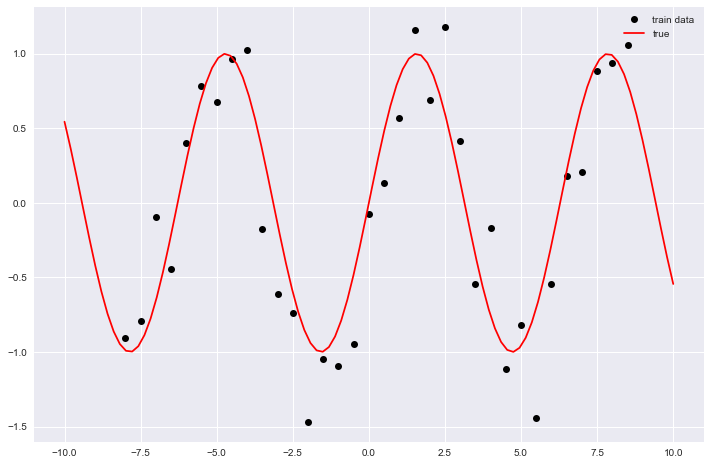

In [46]:
_, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.legend()

In [47]:
import gpytorch
from skorch.probabilistic import ExactGPRegressor

/home/vinh/work/skorch/skorch/probabilistic.py:35: SkorchWarning: The API of the Gaussian Process estimators is experimental and may change in the future
  "change in the future", SkorchWarning)


In [48]:
class RbfModule(gpytorch.models.ExactGP):
    def __init__(self, likelihood, noise_init=None):
        super().__init__(train_inputs=None, train_targets=None, likelihood=likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [49]:
gpr = ExactGPRegressor(
    RbfModule,
    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    device=DEVICE,
    batch_size=-1,
)
gpr.initialize()

<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
  ),
)

In [50]:
samples = gpr.sample(X_train, n_samples=50)
samples = samples.detach().cpu().numpy()  # turn into numpy array

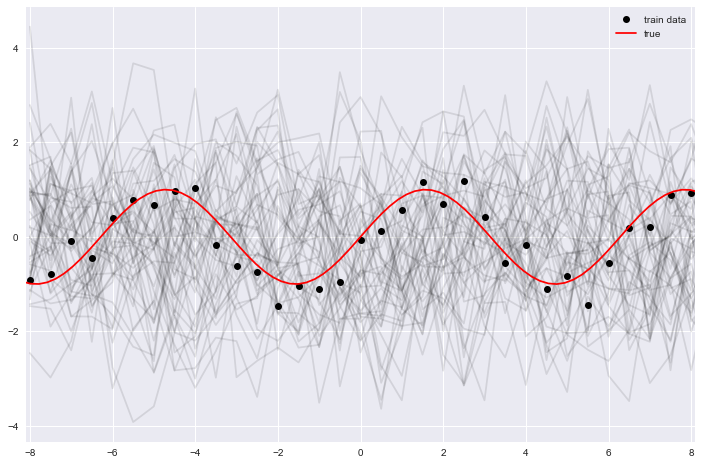

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

In [52]:
gpr.fit(X_train, y_train)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        1.1971  0.0106
      2        1.1668  0.0040
      3        1.1360  0.0040
      4        1.1047  0.0041
      5        1.0733  0.0041
      6        1.0419  0.0044
      7        1.0103  0.0106
      8        0.9788  0.0066
      9        0.9478  0.0072
     10        0.9175  0.0054
     11        0.8879  0.0099
     12        0.8594  0.0043
     13        0.8321  0.0056
     14        0.8066  0.0049
     15        0.7829  0.0106
     16        0.7614  0.0062
     17        0.7423  0.0103
     18        0.7257  0.0075
     19        0.7117  0.0079
     20        0.7001  0.0108


<class 'skorch.probabilistic.ExactGPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  ),
)

/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


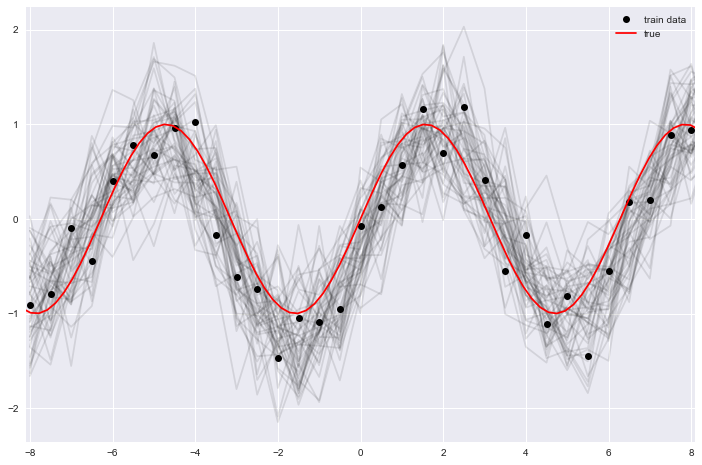

In [53]:
samples = gpr.sample(X_train, 50)
samples = samples.detach().cpu().numpy()  # turn into numpy array

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

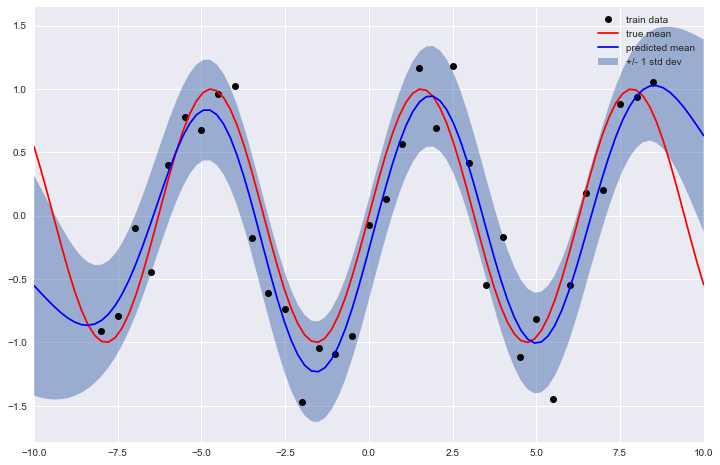

In [54]:
y_pred, y_std = gpr.predict(X_valid, return_std=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true mean')
ax.plot(X_valid, y_pred, color='blue', label='predicted mean')
ax.set_xlim([-10, 10])
ax.fill_between(X_valid, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.legend()

## Hugging Face integration

In [55]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skorch.callbacks import ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
from transformers import AutoModelForSequenceClassification

In [56]:
X, y = fetch_20newsgroups(return_X_y=True)

In [57]:
print(X[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [58]:
TOKENIZER = "bert-base-uncased"
PRETRAINED_MODEL = "distilbert-base-uncased"

In [59]:
class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels

        self.reset_weights()

    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels
        )

    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [60]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=len(set(y_train)),
        optimizer=torch.optim.AdamW,
        lr=5e-5,
        max_epochs=3,
        criterion=nn.CrossEntropyLoss(),
        batch_size=8,
        iterator_train__shuffle=True,
        device=DEVICE,
        callbacks=[
            ProgressBar(),
        ],
    )),
])

In [61]:
# pipeline.fit(X, y)

### training your own tokenizer

In [62]:
from skorch.hf import HuggingfaceTokenizer
import tokenizers
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.processors import TemplateProcessing

In [63]:
hf_tokenizer = HuggingfaceTokenizer(
    tokenizer=Tokenizer,
    model=WordPiece,
    model__unk_token="[UNK]",
    trainer__vocab_size=2000,
    trainer__special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],
    trainer__show_progress=True,
    normalizer=tokenizers.normalizers.Sequence(
        [NFD(), Lowercase(), StripAccents()]
    ),
    pre_tokenizer=tokenizers.pre_tokenizers.Sequence(
        [Whitespace(), Digits(individual_digits=True)]
    ),
    post_processor=TemplateProcessing,
    post_processor__single="[CLS] $A [SEP]",
    post_processor__pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    post_processor__special_tokens=[("[CLS]", 1), ("[SEP]", 2)],
    max_length=300,
)

In [64]:
%time hf_tokenizer.fit(X)

CPU times: user 18.7 s, sys: 461 ms, total: 19.2 s
Wall time: 3.03 s


HuggingfaceTokenizer(max_length=300,
                     model=<class 'tokenizers.models.WordPiece'>,
                     model__unk_token='[UNK]',
                     normalizer=<tokenizers.normalizers.Sequence object at 0x7f5c8f5dff70>,
                     post_processor=<class 'tokenizers.processors.TemplateProcessing'>,
                     post_processor__pair='[CLS] $A [SEP] $B:1 [SEP]:1',
                     post_processor__single='[CLS] $A [SEP]',
                     post_processor__special_tokens=[('[CLS]', 1),
                                                     ('[SEP]', 2)],
                     pre_tokenizer=<tokenizers.pre_tokenizers.Sequence object at 0x7f5c8f5dff30>,
                     tokenizer=<class 'tokenizers.Tokenizer'>,
                     trainer__show_progress=True,
                     trainer__special_tokens=['[UNK]', '[CLS]', '[SEP]',
                                              '[PAD]', '[MASK]'],
                     trainer__vocab_size=2000)

In [65]:
hf_tokenizer.vocabulary_

{'against': 1208,
 'using': 935,
 'came': 1753,
 'ot': 1918,
 'it': 213,
 'mark': 972,
 'bill': 1116,
 'some': 370,
 '##ich': 368,
 '##ne': 785,
 'either': 1278,
 '##ine': 410,
 'tw': 587,
 '##ipp': 1048,
 'tm': 1466,
 '?"': 1914,
 'rep': 523,
 'wes': 1976,
 'turkish': 1807,
 'most': 660,
 'esp': 1670,
 '##ris': 1220,
 '##ach': 478,
 'answ': 1213,
 '##work': 1689,
 'death': 1779,
 'hear': 1999,
 'wrong': 1332,
 'few': 1078,
 'th': 163,
 'russ': 1617,
 'au': 1230,
 '##augh': 1516,
 'al': 237,
 '##---': 1191,
 'department': 1684,
 '##oice': 1707,
 '##-': 130,
 'gover': 850,
 'd': 53,
 '##ety': 1380,
 'fam': 1846,
 '##bm': 1269,
 'bu': 564,
 'med': 1026,
 '##ij': 1694,
 'wal': 1720,
 'get': 443,
 '##%%': 1256,
 '##~~': 367,
 '##ary': 481,
 'add': 1090,
 'g': 56,
 'again': 738,
 'version': 1115,
 'certain': 1223,
 '##ided': 1742,
 '##thing': 855,
 'rock': 1908,
 'ul': 1711,
 'great': 1042,
 'reg': 792,
 '##(': 142,
 'quest': 683,
 'pop': 1454,
 'better': 979,
 '##im': 238,
 'beh': 1415,
 '

In [66]:
Xt = hf_tokenizer.transform(X[:1])
Xt

{'input_ids': tensor([[   1,  246,   37,  356,   95,  115,  183,   43, 1323,  109,   25, 1022,
          102,   25,  248,   19,  705,   18,   68,  337, 1081,   20,  319,   37,
          352,  548,  198,  258,   12,  122,  518,   24,  477,   24,  504,   37,
         1539,   99,   30,   25, 1323,  109,   25, 1022,  102,   25,  248,  331,
           37,  483,  186,  556,  112,  949,   23, 1902,  432,  654,  120,  327,
           37,   28,   32,   58,  292, 1768,  179,  303,  774,  387,  345,  584,
          324,  104,  346,  173,  330,  214,  258,  548,   58,  522,  127,  167,
          482,  794,   25,  213,  292,   50,   29,   24,  266,  172,  320,  359,
          113,  548,   23,  694,  180,  182,  221,  246,  167,  545,  780,   33,
           27,   68,   26, 1000,  211,   34,   27,   68,   25,  213,  292, 1302,
           50, 1736,   99,  120, 1434,   25,  167,  266,  605,  490,  842, 1460,
           25,  181, 1090,  664,   23,  167,  233,  674,  564,  109,  553,  292,
          305,

In [67]:
hf_tokenizer.inverse_transform(Xt)[0].replace(' ##', '|')

"from : le|r|x|st @ wa|m. um|d. edu ( where's my thing ) subject : what car is this!|? nntp - posting - host : ra|c 3. wa|m. um|d. edu organization : university of mar|y|land, colle|ge par|k lines : 1 5 i was wonder|ing if anyone out there could en|l|ight|en me on this car i sa|w the other day. it was a 2 - do|or sp|ort|s car, look|ed to be from the la|te 6 0 s / ear|ly 7 0 s. it was called a bri|c|k|lin. the do|ors were really small. in add|ition, the fr|ont bu|m|per was se|par|ate from the rest of the bo|d|y. this is all i know. if anyone can tell|m|e a mod|el name, engine spec|s, years of product|ion, where this car is made, hist|ory, or what|ever info you have on this fun|k|y looking car, please e - mail. thanks, - il ---|- br|ought to you by your ne|igh|bo|r|h|ood le|r|x|st ---|-"